# ARIMA Models: The Powerhouse of Time Series Forecasting

## Learning Objectives
By the end of this notebook, you will be able to:
1. Understand what ARIMA is and why it's powerful
2. Explain AR, I, and MA components conceptually
3. Use auto-ARIMA to automatically find the best model
4. Build and evaluate ARIMA forecasts
5. Compare ARIMA to baseline methods


## Introduction: Why ARIMA?

**ARIMA is one of the most powerful and widely used forecasting methods!**

We've learned about:
- Simple methods (naive, moving average) - good baselines but limited
- Stationarity - required for ARIMA
- Autocorrelation - helps understand data patterns

Now we'll combine everything into **ARIMA** - a model that can handle trends, patterns, and memory all at once!

**What ARIMA does:** ARIMA combines three powerful ideas:
1. **AR (AutoRegressive):** Uses past values to predict future
2. **I (Integrated):** Handles trends through differencing
3. **MA (Moving Average):** Uses past errors to improve predictions

**Think of it like this:** Instead of just saying "tomorrow = today" (naive) or "tomorrow = average" (moving average), ARIMA learns complex patterns from the data.

**Real-World Example:** A retailer forecasting sales might use:
- Last month's sales (AR component)
- How much sales changed (I component - differencing)
- How wrong previous forecasts were (MA component)

**Think About It:** Why do you think combining these three ideas would be more powerful than using just one?


In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')

print("Libraries imported successfully")
print("Note: We're using pmdarima for auto-ARIMA - it finds the best parameters automatically")


Libraries imported successfully
Note: We're using pmdarima for auto-ARIMA - it finds the best parameters automatically


In [13]:
# Load and prepare the data
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Split into train and test (time-aware split)
split_point = int(len(data) * 0.8)
train = data.iloc[:split_point].copy()
test = data.iloc[split_point:].copy()

print("✅ Data loaded and split successfully")
print(f"Training: {train.index.min()} to {train.index.max()} ({len(train)} months)")
print(f"Testing: {test.index.min()} to {test.index.max()} ({len(test)} months)")


✅ Data loaded and split successfully
Training: 1949-01-01 00:00:00 to 1958-07-01 00:00:00 (115 months)
Testing: 1958-08-01 00:00:00 to 1960-12-01 00:00:00 (29 months)


## Section 1: Understanding ARIMA Components

### What Does ARIMA Stand For?

**ARIMA = AutoRegressive Integrated Moving Average**

It's a combination of three components:

### Component 1: AR (AutoRegressive)

**What it does:** Uses past values to predict future values

**Simple explanation:** "Today's value depends on yesterday's value, the day before, etc."

**Example:** If sales were high last month and the month before, they might be high this month too.

**The "p" parameter:** How many past values to use
- p = 1: Use only last month
- p = 2: Use last 2 months
- p = 12: Use last 12 months

**Think of it like this:** AR is the "memory" component - it remembers what happened before.

### Component 2: I (Integrated)

**What it does:** Handles trends through differencing

**Simple explanation:** Instead of using actual values, use the changes (differences)

**Example:** Instead of predicting sales level, predict how much sales changed.

**The "d" parameter:** How many times to difference
- d = 0: No differencing (data is already stationary)
- d = 1: Difference once (remove trend)
- d = 2: Difference twice (if one difference wasn't enough)

**Think of it like this:** I is the "stabilizer" - it removes trends to make data stationary.

### Component 3: MA (Moving Average)

**What it does:** Uses past forecast errors to improve predictions

**Simple explanation:** "If I was wrong yesterday, I'll adjust today's forecast"

**Example:** If you predicted 100 but actual was 110, you were 10 units too low. The MA component uses this information.

**The "q" parameter:** How many past errors to use
- q = 1: Use only last error
- q = 2: Use last 2 errors
- q = 12: Use last 12 errors

**Think of it like this:** MA is the "error correction" component - it learns from mistakes.

### Putting It Together: ARIMA(p, d, q)

**ARIMA(1, 1, 1) means:**
- p = 1: Use 1 past value (AR)
- d = 1: Difference once (I)
- q = 1: Use 1 past error (MA)

**ARIMA(2, 1, 0) means:**
- p = 2: Use 2 past values (AR only)
- d = 1: Difference once (I)
- q = 0: Don't use past errors (no MA)

**Think About It:** What would ARIMA(0, 1, 1) mean? (Hint: No AR, just I and MA)


## Section 2: Why Use Auto-ARIMA?

### The Problem with Manual Parameter Selection

Choosing (p, d, q) manually is:
- **Time-consuming:** You'd need to try many combinations
- **Complex:** Hard to know which is best
- **Error-prone:** Easy to miss the best model

### The Solution: Auto-ARIMA

**Auto-ARIMA** automatically:
1. Tries many (p, d, q) combinations
2. Finds the best one using AIC (a quality metric)
3. Handles differencing automatically
4. Saves you hours of work!

**Think of it like this:** Instead of manually tuning a radio, auto-ARIMA automatically finds the best station!

### When to Use Auto-ARIMA

- **Always!** (For beginners and most practical applications)
- When you want the best model without manual tuning
- When you have limited time
- When you're not sure what parameters to use

**Note:** Understanding what (p, d, q) mean is still important for interpreting results, but you don't need to choose them manually!


## Section 3: Building an ARIMA Model

### Step 1: Prepare the Data

ARIMA needs stationary data. Let's apply Box-Cox transform first (we learned this in notebook 07):


In [14]:
# Apply Box-Cox transform to stabilize variance
# Auto-ARIMA will handle differencing automatically
train_boxcox, lambda_param = boxcox(train['#Passengers'])

print("✅ Box-Cox transform applied")
print(f"Lambda parameter: {lambda_param:.4f}")
print(f"💡 Lambda close to 0 means log transform was appropriate")


✅ Box-Cox transform applied
Lambda parameter: 0.0449
💡 Lambda close to 0 means log transform was appropriate


### Step 2: Use Auto-ARIMA to Find Best Model

Auto-ARIMA will automatically:
- Try different (p, d, q) combinations
- Find the best one
- Handle differencing
- Return the best model


In [15]:
# Use auto_arima to find the best ARIMA model
# This automatically tries different (p, d, q) combinations and picks the best one
print("🔍 Auto-ARIMA is searching for the best model...")
print("   This may take a minute - it's trying many combinations")

model = auto_arima(train_boxcox,
                   start_p=0, start_q=0,  # Start from simple models
                   max_p=5, max_q=5,      # Don't go too complex
                   d=1,                   # Try differencing once
                   seasonal=False,         # We'll handle seasonality in next notebook
                   stepwise=True,          # Use stepwise search (faster)
                   suppress_warnings=True,
                   error_action='ignore',
                   trace=False)

print("✅ Auto-ARIMA found the best model")
print(f"\nBest ARIMA model: {model.order}")
print(f"   p = {model.order[0]} (AR - uses {model.order[0]} past values)")
print(f"   d = {model.order[1]} (I - differences {model.order[1]} times)")
print(f"   q = {model.order[2]} (MA - uses {model.order[2]} past errors)")
print(f"\n💡 Auto-ARIMA chose these parameters automatically")
print("   It tried many combinations and picked the best one based on AIC.")


🔍 Auto-ARIMA is searching for the best model...
   This may take a minute - it's trying many combinations
✅ Auto-ARIMA found the best model

Best ARIMA model: (1, 1, 5)
   p = 1 (AR - uses 1 past values)
   d = 1 (I - differences 1 times)
   q = 5 (MA - uses 5 past errors)

💡 Auto-ARIMA chose these parameters automatically
   It tried many combinations and picked the best one based on AIC.


### Step 3: Generate Forecasts

Now let's use our model to forecast the test period:


In [16]:
# Generate forecasts for the test period
# The model was trained on Box-Cox transformed data, so forecasts are also transformed
forecasts_boxcox = model.predict(n_periods=len(test))

# Convert forecasts back to original scale using inverse Box-Cox
forecasts = inv_boxcox(forecasts_boxcox, lambda_param)

print("✅ Forecasts generated")
print(f"Forecasted {len(forecasts)} future periods")
print(f"Forecast range: {forecasts.min():.0f} to {forecasts.max():.0f} passengers")
print(f"\n💡 Remember: We transformed the data, so we need to transform forecasts back")


✅ Forecasts generated
Forecasted 29 future periods
Forecast range: 407 to 565 passengers

💡 Remember: We transformed the data, so we need to transform forecasts back


## Section 4: Visualizing ARIMA Forecasts

Let's see how well our ARIMA model performs:


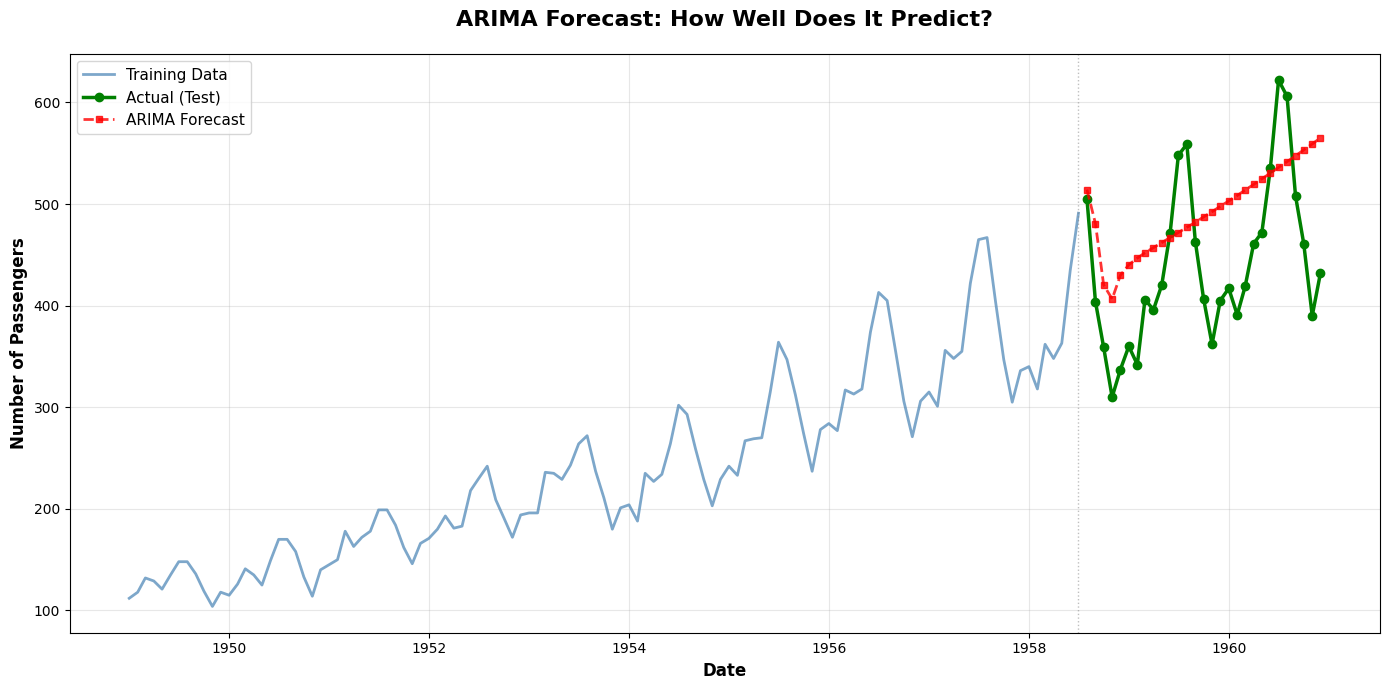


🔍 Visual Analysis:
✅ How close are the red and green lines?
✅ Does ARIMA capture the trend?
✅ Does ARIMA capture seasonality?
✅ Is it better than the naive forecast we saw earlier?


In [17]:
# Visualize ARIMA forecasts
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['#Passengers'], linewidth=2, color='steelblue', 
         label='Training Data', alpha=0.7)
plt.plot(test.index, test['#Passengers'], linewidth=2.5, color='green', 
         label='Actual (Test)', marker='o', markersize=6)
plt.plot(test.index, forecasts, linewidth=2, color='red', 
         linestyle='--', label='ARIMA Forecast', alpha=0.8, marker='s', markersize=4)
plt.axvline(x=train.index.max(), color='gray', linestyle=':', linewidth=1, alpha=0.5)
plt.title('ARIMA Forecast: How Well Does It Predict?', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Number of Passengers', fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🔍 Visual Analysis:")
print("✅ How close are the red and green lines?")
print("✅ Does ARIMA capture the trend?")
print("✅ Does ARIMA capture seasonality?")
print("✅ Is it better than the naive forecast we saw earlier?")


## Section 5: Evaluating ARIMA Performance

Now let's use the evaluation metrics we learned in notebook 06 to measure how good our ARIMA model is:


In [18]:
# Calculate evaluation metrics
# (We learned these in notebook 06!)
actual = test['#Passengers'].values

def calculate_metrics(actual, forecast, model_name="Model"):
    """Calculate and display MAE, MAPE, and RMSE"""
    mae = mean_absolute_error(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    
    print(f"\n{'='*60}")
    print(f"Evaluation Results: {model_name}")
    print(f"{'='*60}")
    print(f"MAE  (Mean Absolute Error):      {mae:>10.2f} passengers")
    print(f"MAPE (Mean Absolute % Error):    {mape:>10.2f}%")
    print(f"RMSE (Root Mean Squared Error): {rmse:>10.2f} passengers")
    print(f"{'='*60}")
    
    return {'MAE': mae, 'MAPE': mape, 'RMSE': rmse}

# Evaluate ARIMA
arima_metrics = calculate_metrics(actual, forecasts, "ARIMA Model")



Evaluation Results: ARIMA Model
MAE  (Mean Absolute Error):           74.30 passengers
MAPE (Mean Absolute % Error):         18.04%
RMSE (Root Mean Squared Error):      83.45 passengers


### Comparing ARIMA to Baseline Methods

Let's see if ARIMA is actually better than simple methods:


In [19]:
# Create baseline forecasts for comparison
# Naive forecast
naive_forecast = [train['#Passengers'].iloc[-1]] * len(test)

# Seasonal naive forecast
test['month_num'] = test.index.month
train['month_num'] = train.index.month
seasonal_naive_forecast = []
for idx, row in test.iterrows():
    month = row['month_num']
    same_month = train[train['month_num'] == month]
    if len(same_month) > 0:
        seasonal_naive_forecast.append(same_month['#Passengers'].iloc[-1])
    else:
        seasonal_naive_forecast.append(train['#Passengers'].iloc[-1])

# Calculate metrics for all methods
results_comparison = []

# Naive
naive_metrics = calculate_metrics(actual, naive_forecast, "Naive Forecast")
results_comparison.append({
    'Model': 'Naive',
    'MAE': naive_metrics['MAE'],
    'MAPE': naive_metrics['MAPE'],
    'RMSE': naive_metrics['RMSE']
})

# Seasonal Naive
seasonal_naive_metrics = calculate_metrics(actual, seasonal_naive_forecast, "Seasonal Naive Forecast")
results_comparison.append({
    'Model': 'Seasonal Naive',
    'MAE': seasonal_naive_metrics['MAE'],
    'MAPE': seasonal_naive_metrics['MAPE'],
    'RMSE': seasonal_naive_metrics['RMSE']
})

# ARIMA
results_comparison.append({
    'Model': 'ARIMA',
    'MAE': arima_metrics['MAE'],
    'MAPE': arima_metrics['MAPE'],
    'RMSE': arima_metrics['RMSE']
})

# Create comparison table
comparison_df = pd.DataFrame(results_comparison)
print("\n" + "="*70)
print("MODEL COMPARISON: Which Method is Best?")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

print("\n📊 Key Insights:")
print("✅ Lower values = Better forecasts")
print("✅ Compare ARIMA to baselines - is it actually better?")
print("💡 ARIMA should outperform naive, but might be similar to seasonal naive")
print("   (Seasonal naive is strong for seasonal data)")



Evaluation Results: Naive Forecast
MAE  (Mean Absolute Error):           81.45 passengers
MAPE (Mean Absolute % Error):         20.20%
RMSE (Root Mean Squared Error):      93.13 passengers

Evaluation Results: Seasonal Naive Forecast
MAE  (Mean Absolute Error):           64.76 passengers
MAPE (Mean Absolute % Error):         14.04%
RMSE (Root Mean Squared Error):      75.23 passengers

MODEL COMPARISON: Which Method is Best?
         Model       MAE      MAPE      RMSE
         Naive 81.448276 20.200133 93.133941
Seasonal Naive 64.758621 14.037901 75.233888
         ARIMA 74.302693 18.037508 83.452013

📊 Key Insights:
✅ Lower values = Better forecasts
✅ Compare ARIMA to baselines - is it actually better?
💡 ARIMA should outperform naive, but might be similar to seasonal naive
   (Seasonal naive is strong for seasonal data)


### Visual Comparison of All Methods

Let's see all methods plotted together:


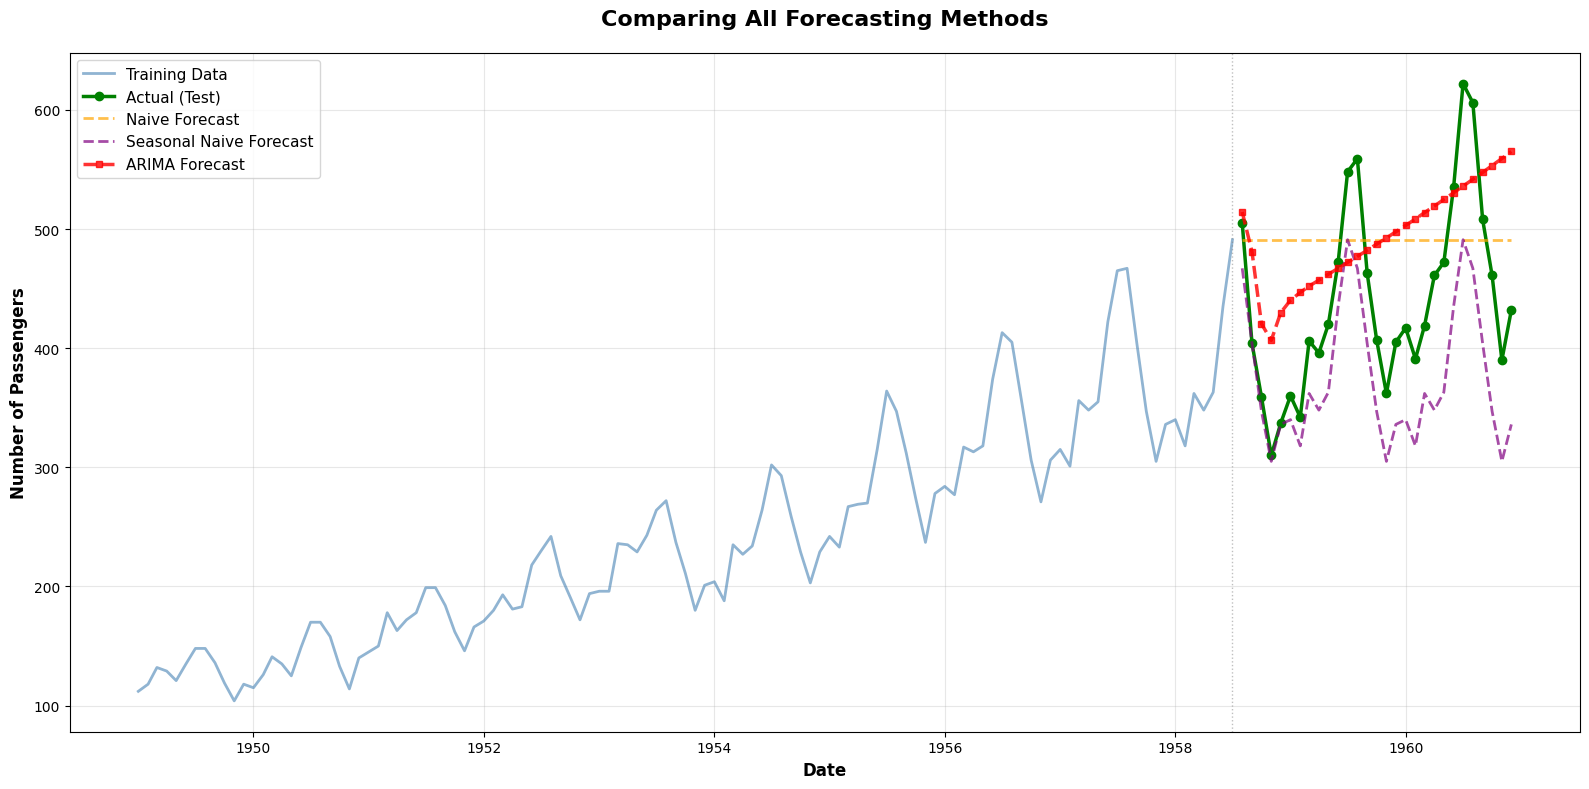


🔍 Visual Comparison:
✅ Naive: Flat line (misses everything)
✅ Seasonal Naive: Captures seasonality but misses trend
✅ ARIMA: Should capture both trend and seasonality

💡 Which forecast looks closest to the actual (green) line?


In [20]:
# Visual comparison of all forecasting methods
plt.figure(figsize=(16, 8))
plt.plot(train.index, train['#Passengers'], linewidth=2, color='steelblue', 
         label='Training Data', alpha=0.6)
plt.plot(test.index, test['#Passengers'], linewidth=2.5, color='green', 
         label='Actual (Test)', marker='o', markersize=6)
plt.plot(test.index, naive_forecast, linewidth=2, color='orange', 
         linestyle='--', label='Naive Forecast', alpha=0.7)
plt.plot(test.index, seasonal_naive_forecast, linewidth=2, color='purple', 
         linestyle='--', label='Seasonal Naive Forecast', alpha=0.7)
plt.plot(test.index, forecasts, linewidth=2.5, color='red', 
         linestyle='--', label='ARIMA Forecast', alpha=0.8, marker='s', markersize=4)
plt.axvline(x=train.index.max(), color='gray', linestyle=':', linewidth=1, alpha=0.5)
plt.title('Comparing All Forecasting Methods', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Number of Passengers', fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🔍 Visual Comparison:")
print("✅ Naive: Flat line (misses everything)")
print("✅ Seasonal Naive: Captures seasonality but misses trend")
print("✅ ARIMA: Should capture both trend and seasonality")
print("\n💡 Which forecast looks closest to the actual (green) line?")


## Section 6: Understanding ARIMA Results

### What the Model Learned

Our ARIMA model learned:
- **AR component (p):** How many past values matter
- **I component (d):** How much differencing was needed
- **MA component (q):** How many past errors to use

**Business Interpretation:**
- The model found patterns in past passenger counts
- It learned how passenger counts change over time
- It uses this knowledge to predict future counts

### When ARIMA Works Well

ARIMA is great for:
- **Data with trends:** Handles growth/decline patterns
- **Data with memory:** When past values influence future
- **Short to medium-term forecasts:** Usually 1-12 periods ahead
- **Univariate data:** Single time series (not multiple variables)

### When ARIMA Struggles

ARIMA may not work well for:
- **Strong seasonality:** Need SARIMA instead (next notebook!)
- **Long-term forecasts:** Accuracy decreases over time
- **Structural breaks:** When patterns suddenly change
- **External factors:** Can't handle events like promotions, holidays

**Think About It:** Why do you think ARIMA might struggle with very long-term forecasts (like 5 years ahead)?


## Summary: Key Takeaways

This notebook introduced you to ARIMA models:

### What We Learned

1. **ARIMA Components:**
   - **AR (AutoRegressive):** Uses past values (the "memory")
   - **I (Integrated):** Handles trends through differencing (the "stabilizer")
   - **MA (Moving Average):** Uses past errors (the "error corrector")

2. **ARIMA Parameters (p, d, q):**
   - p = number of past values to use
   - d = number of times to difference
   - q = number of past errors to use

3. **Auto-ARIMA:**
   - Automatically finds best (p, d, q)
   - Saves time and effort
   - Usually finds better models than manual selection

4. **Evaluation:**
   - Always compare to baseline methods
   - Use MAE, MAPE, RMSE metrics
   - Visual evaluation is also important

### Key Insights

- **ARIMA is powerful:** Combines three ideas into one model
- **Auto-ARIMA is essential:** Manual parameter selection is too complex
- **Evaluation matters:** Always compare to simple baselines
- **Context matters:** ARIMA works well for trends and patterns

### Why This Matters

ARIMA helps you:
- Forecast data with trends and patterns
- Handle complex time series relationships
- Make better predictions than simple methods
- Understand what drives your forecasts


**Remember:** ARIMA is powerful, but it needs stationary data and works best for short to medium-term forecasts!
